<a href="https://colab.research.google.com/github/kihtrak-tns/Build-Self-Driving-car-using-NVIDIA-Jetson-Nano/blob/master/Traffic_Signs_Starter_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

Using TensorFlow backend.


In [0]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
np.random.seed(0)

# 'with' is used to execute two operations as a pair and invoke another operation in between

In [0]:
with open ('german-traffic-signs/train.p', 'rb') as read_file:
  train_data = pickle.load(read_file)
with open ('german-traffic-signs/valid.p', 'rb') as read_file:
  val_data = pickle.load(read_file)
with open ('german-traffic-signs/test.p', 'rb') as read_file:
  test_data = pickle.load(read_file)

X_train, y_train = train_data['features'], train_data['labels']
  # features: corresponds to values of training images in pixel representation
  # labels: labels in image that corresponds to a class, helps neural network learn function that
  ## properly classifies the input data.
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [0]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of training images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of validation images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of testing images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"


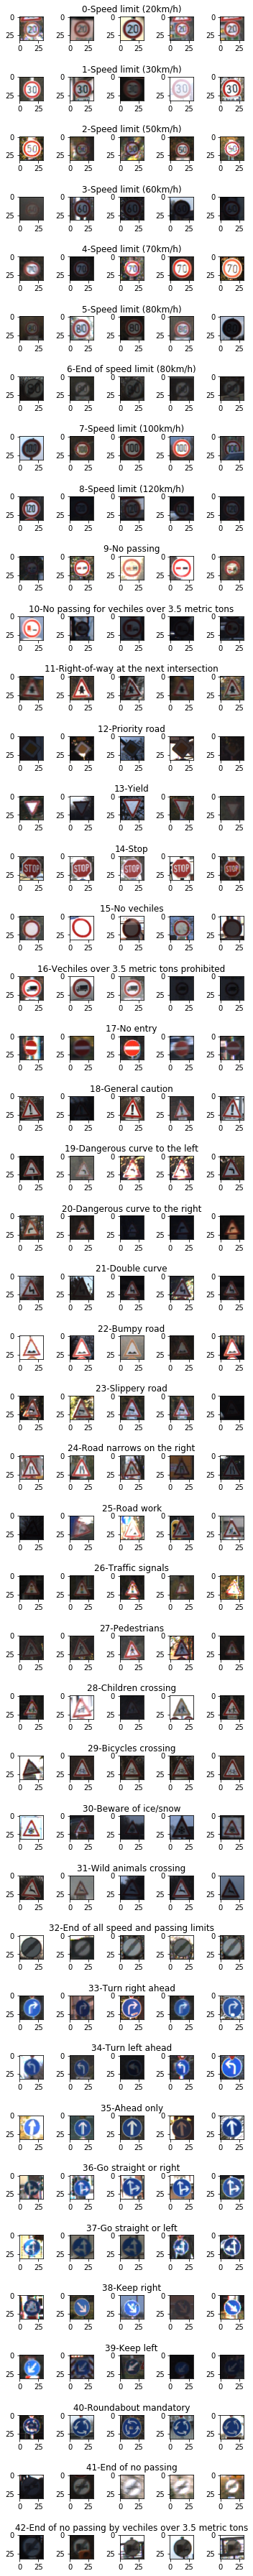

In [0]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []

cols = 5
num_classes = 43

# We have a bigger list of classes compared to MNIST implementation
fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50) )
fig.tight_layout()

for i in range(cols) :
  # .iterrows is going to iterate throughout as (index, series), where Series gives us the information of the index
  ## and row is a place holder
    for j, row in data.iterrows() :
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected-1)), :, :], cmap=plt.get_cmap("gray"))
        #  axs[j][i].axis("off")
        if i == 2 :
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))

# We need to preprocess our images before training them for better results. The color of an image is least significant compared to the edges, shapes in the image. Hence, we convert the image to a grayscale image with depth 1


(32, 32)


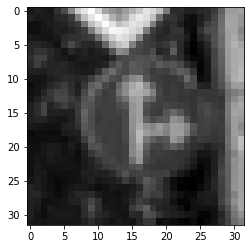

In [0]:
import cv2

def grayscale(img) :
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])

# imshow() by default sets a colormap for the images. 
plt.imshow(img, cmap='gray')
print(img.shape)

# We perform Histogram Equalization on our images. HE can be performed only on grayscale images and not on RGB images. 


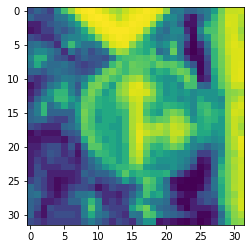

In [0]:
def equalize(img) :
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)

In [0]:
def preprocessing(img) :
  img = grayscale(img)
  img = equalize(img)
  norm_img = img/255
  return norm_img

# map() iterate througout the entire array and for each element of the array it returns the updated element based
## on the function executed on each element of the array.
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


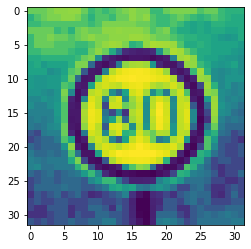

In [0]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
print(X_train.shape)

## Convolution is performed by filters on all channels of the image, hence we need to reshape the training image with its depth

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)



# We try to augment our data by providing different perspectives of our data set to the model

In [0]:
from keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator class allow us to define the type of transformations on dataset and allows us to set range 
## on the transformations. 
# width_shift_range -> for images that are necessarily not centered ( 10 pixels or 10% of our image's width)
# zoom_range -> can be described b/w 0 & 1 float with range (1-float value, 1+float value)

datagen = ImageDataGenerator(width_shift_range = 0.1, 
                             height_shift_range = 0.1,
                             zoom_range = 0.2, 
                             shear_range = 0.1, 
                             rotation_range = 10)

# .fit() allows the ImageGenerator (iterator) to calculate any statistics required to perform the transformations. IMG requires 
## batches of dataset only on request and not performs on all the dataset.
datagen.fit(X_train)

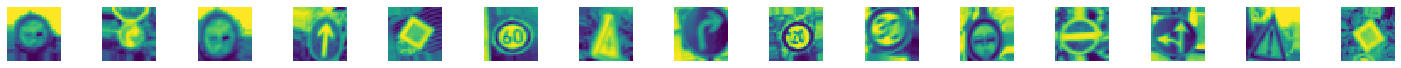

In [0]:
# .flow() requests IMG for images
# next() -> we get a new batch of 20 items each time when we call the iterator
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20,5))
fig.tight_layout()

for i in range(15) : 
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [0]:
# One-hot encoding

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [0]:
""" def leNet_model() :
  model = Sequential()
  # The input image fed is the grayscale image of size 32 x 32 x 1. Convolving a filter of size 5 x 5 (stride = 1) over 32 x 32
  ## we loose 2 pixels of thickness on all the borders yielding 28 x 28 for each feature map
  model.add(Conv2D(30, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Conv2D(15, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  # After the second round of convolution and pooling, the depth still remains the same and we have 6 x 6 x 15 layers will be 
  ## now 'flattened' out as a 1-D (shape: 540) to be fed to the fully connected layer.  
  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  # A Dropout of 0 refers to no subtracted nodes and 1 refers to all the input nodes dropped
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  # To compile our model
  model.compile(Adam(lr = 0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model """

" def leNet_model() :\n  model = Sequential()\n  # The input image fed is the grayscale image of size 32 x 32 x 1. Convolving a filter of size 5 x 5 (stride = 1) over 32 x 32\n  ## we loose 2 pixels of thickness on all the borders yielding 28 x 28 for each feature map\n  model.add(Conv2D(30, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))\n  model.add(MaxPooling2D(pool_size = (2,2)))\n  model.add(Conv2D(15, (3, 3), activation = 'relu'))\n  model.add(MaxPooling2D(pool_size = (2,2)))\n  # After the second round of convolution and pooling, the depth still remains the same and we have 6 x 6 x 15 layers will be \n  ## now 'flattened' out as a 1-D (shape: 540) to be fed to the fully connected layer.  \n  model.add(Flatten())\n  model.add(Dense(500, activation = 'relu'))\n  # A Dropout of 0 refers to no subtracted nodes and 1 refers to all the input nodes dropped\n  model.add(Dropout(0.5))\n  model.add(Dense(num_classes, activation = 'softmax'))\n  # To compile our model\n  model.com

# To fine - tune the model, we can 1) have a lower learning rate; 2) increase epochs; 3) add more layers, filters

In [0]:
def modified_model() :
  model = Sequential()
  # The input image fed is the grayscale image of size 32 x 32 x 1. Convolving a filter of size 5 x 5 (stride = 1) over 32 x 32
  ## we loose 2 pixels of thickness on all the borders yielding 28 x 28 for each feature map
  model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
  model.add(Conv2D(60, (5, 5), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Conv2D(30, (3, 3), activation = 'relu'))
  model.add(Conv2D(30, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  # model.add(Dropout(0.5)) -> To minimize overfitting


  # After the second round of convolution and pooling, the depth still remains the same and we have 6 x 6 x 15 layers will be 
  ## now 'flattened' out as a 1-D (shape: 540) to be fed to the fully connected layer.  
  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  # A Dropout of 0 refers to no subtracted nodes and 1 refers to all the input nodes dropped
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  # To compile our model
  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [0]:
model = modified_model()
print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0        

In [0]:
# Runs image generator and also trains our model simultaneously with the augmented data
# steps_per_epoch -> amount of batches generated per epoch; we use 100000 images (batch_size * steps_per_epoch)
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size= 50), steps_per_epoch = 2000, epochs = 10, validation_data =(X_val, y_val), shuffle = 1 )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





2000/2000 [==============================] - 54s 27ms/step - loss: 1.1984 - acc: 0.6434 - val_loss: 0.1811 - val_acc: 0.9506
Epoch 2/10
2000/2000 [==============================] - 39s 19ms/step - loss: 0.3985 - acc: 0.8757 - val_loss: 0.0827 - val_acc: 0.9721
Epoch 3/10
2000/2000 [==============================] - 39s 20ms/step - loss: 0.2735 - acc: 0.9137 - val_loss: 0.0658 - val_acc: 0.9778
Epoch 4/10
2000/2000 [==============================] - 39s 19ms/step - loss: 0.2182 - acc: 0.9325 - val_loss: 0.0389 - val_acc: 0.9875
Epoch 5/10
2000/2000 [==============================] - 39s 19ms/step - loss: 0.1863 - acc: 0.9428 - val_loss: 0.0265 - val_acc: 0.9927
Epoch 6/10
2000/2000 [==============================] - 39s 20ms/step - loss: 0.1664 - acc: 0.9490 - val_loss: 0.0490 - val_acc: 0.9864
Epoch 7/10
2000/2000 [==============================] - 39s 19ms/step - loss: 0.14

Since we don't have much data to train our model, at some point we face overfitting as well as there's a steep drop in accuracy of our model

Text(0.5, 0, 'epoch')

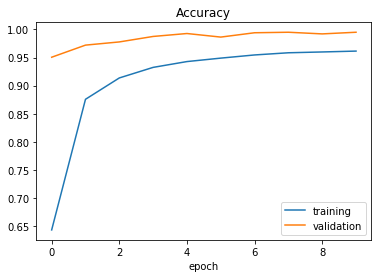

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
            

## It's now evident that we've reduced overfitting since our validation accuracy scores better than our training accuracy and their gap also has been minimized.

# Testing our model with a random image from online

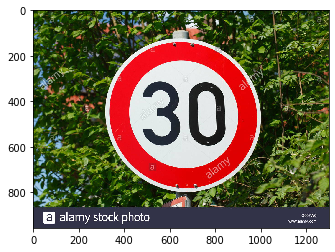

In [0]:
 import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


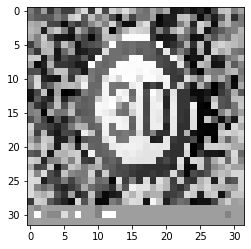

In [0]:
# Preprocess the image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [0]:
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 

In [0]:
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [1]
